In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Load dataset
df = pd.read_csv("three_rows.csv")

# Extract target variable (Y)
Y = df['label']

# Identify categorical amino acid columns
amino_acid_cols = ["A1", "A2", "A3"]

# Apply One-Hot Encoding (OHE) for A1, A2, A3
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
encoded_amino_acids = encoder.fit_transform(df[amino_acid_cols])

# Convert to DataFrame with proper column names
encoded_cols = encoder.get_feature_names_out(amino_acid_cols)
encoded_amino_acids_df = pd.DataFrame(encoded_amino_acids, columns=encoded_cols, index=df.index)

# Drop original A1, A2, A3 columns from df
df.drop(columns=amino_acid_cols, inplace=True)

# Merge the encoded features back into the dataset
df = pd.concat([df, encoded_amino_acids_df], axis=1)

# Select all features starting from 'Feature_1_A1' onward
feature_start_col = df.columns.get_loc("Feature_1_A1")
X_numerical_features = df.iloc[:, feature_start_col:].values

# Normalize numerical features
scaler = StandardScaler()
X_numerical_features_scaled = scaler.fit_transform(X_numerical_features)

# Combine encoded categorical features with scaled numerical features
X_independent = np.hstack((encoded_amino_acids, X_numerical_features_scaled))

# Split dataset into training (80%) and testing (20%)
X_train_final, X_test_final, Y_train_final, Y_test_final = train_test_split(
    X_independent, Y, test_size=0.2, random_state=SEED, stratify=Y
)

# Define improved MLP model architecture
mlp_model_final = keras.Sequential([
    layers.Input(shape=(X_train_final.shape[1],)),
    
    # Hidden layers with BatchNorm, reduced L2, and adjusted dropout
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(0.2),
    
    layers.Dense(256, kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(0.2),
    
    layers.Dense(128, kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(0.2),
    
    layers.Dense(64, kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(0.1),
    
    # Output layer
    layers.Dense(1, activation="sigmoid")
])

# Compile model with custom learning rate
mlp_model_final.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005), 
                        loss='binary_crossentropy', 
                        metrics=['accuracy'])

# Set up EarlyStopping callback with increased patience
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)

# Train model with smaller batch size
history_final = mlp_model_final.fit(
    X_train_final, Y_train_final, epochs=400, batch_size=64,
    validation_data=(X_test_final, Y_test_final), callbacks=[early_stopping], verbose=1
)

# Retrieve final training and testing accuracy
final_train_accuracy = history_final.history['accuracy'][-1]  
final_test_accuracy = history_final.history['val_accuracy'][-1]

# Get predictions on test set
Y_pred_final = mlp_model_final.predict(X_test_final)
Y_pred_final = (Y_pred_final > 0.5).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(Y_test_final, Y_pred_final)
precision = precision_score(Y_test_final, Y_pred_final)
recall = recall_score(Y_test_final, Y_pred_final)
f1 = f1_score(Y_test_final, Y_pred_final)
roc_auc = roc_auc_score(Y_test_final, Y_pred_final)

# Confusion matrix
conf_matrix = confusion_matrix(Y_test_final, Y_pred_final)
TN, FP, FN, TP = conf_matrix.ravel()

# Print results
print(f"Final Training Accuracy: {final_train_accuracy}")
print(f"Final Testing Accuracy: {final_test_accuracy}")
print("\nFinal Classification Report:")
print(classification_report(Y_test_final, Y_pred_final))
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"ROC AUC: {roc_auc}")
print("\nConfusion Matrix:")
print(conf_matrix)
print(f"False Positives: {FP}")
print(f"False Negatives: {FN}")
print(f"True Positives: {TP}")
print(f"True Negatives: {TN}")

Epoch 1/400
61/61 ━━━━━━━━━━━━━━━━━━━━ 18s 85ms/step - accuracy: 0.6335 - loss: 2.2249 - val_accuracy: 0.7634 - val_loss: 2.0945
Epoch 2/400
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.8237 - loss: 1.9326 - val_accuracy: 0.7922 - val_loss: 1.9987
Epoch 3/400
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.9101 - loss: 1.7256 - val_accuracy: 0.7870 - val_loss: 1.9778
Epoch 4/400
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.9444 - loss: 1.5689 - val_accuracy: 0.7973 - val_loss: 1.9112
Epoch 5/400
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.9629 - loss: 1.4274 - val_accuracy: 0.7922 - val_loss: 1.8536
Epoch 6/400
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.9754 - loss: 1.3119 - val_accuracy: 0.7798 - val_loss: 1.8271
Epoch 7/400
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.9769 - loss: 1.2059 - val_accuracy: 0.7726 - val_loss: 1.9061
Epoch 8/400
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.9774 - loss: 1.1256 - val_accuracy: 0

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


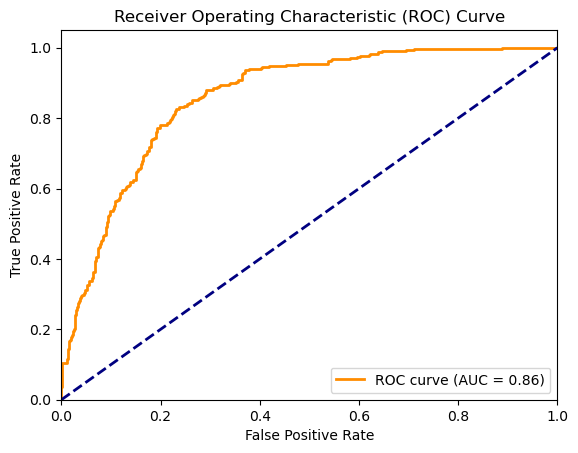

In [4]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(Y_test_final, mlp_model_final.predict(X_test_final))
roc_auc_value = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [2]:
import pandas as pd
data= pd.read_csv("three_rows.csv")
data

,label,PID,sequence_window,Position,A1,A2,A3,Feature_1_A1,Feature_2_A1,Feature_3_A1,...,Feature_2551_A3,Feature_2552_A3,Feature_2553_A3,Feature_2554_A3,Feature_2555_A3,Feature_2556_A3,Feature_2557_A3,Feature_2558_A3,Feature_2559_A3,Feature_2560_A3
0,1,A6NK06,DRSDTFYGHWRKPLSQEDLEEKFRANASKMLSWDTVESLIKIVKNL...,425,N,A,S,0.102742,-0.119910,-0.027533,...,-0.078203,-0.084310,0.065748,-0.228966,0.036301,-0.018697,0.085146,0.020588,0.341293,-0.048000
1,1,A6NNS2,SDISCVPDVAKEVLDCYGCVDILINNASVKVKGPAHKISLELDKKI...,127,N,A,S,-0.022113,0.083495,-0.126984,...,-0.184083,0.102966,-0.167790,-0.333483,0.029495,-0.031681,0.034087,0.181541,-0.157947,0.048032
2,1,O00629,EDICEDSDIDGDYRVQNTSLEAIVQNASSDNQGIQLSAVQAARKLL...,79,N,A,S,0.021770,-0.157243,-0.075847,...,0.188142,0.109580,0.077411,-0.132088,-0.035766,-0.131703,-0.248742,0.255177,0.069867,-0.045436
3,1,O14556,SPDAPMFVMGVNENDYNPGSMNIVSNASCTTNCLAPLAKVIHERFG...,221,N,A,S,-0.044578,-0.150903,-0.041899,...,0.106943,-0.096906,0.080183,0.112341,-0.094210,-0.085395,0.108746,0.011008,0.136389,0.094940
4,1,O14657,AITGYLSYNDIYCRFAECCREERPLNASALKLDLEEKLFGQHLATE...,64,N,A,S,-0.148869,0.130875,0.004870,...,0.150824,-0.104798,0.210740,-0.053255,-0.047107,-0.073082,0.138224,0.074727,-0.209900,-0.045697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4855,0,Q17QL5,NNIREIEIDYTGTDPSSPCNKCLSPNVTPCVCTINFTLEQSFEGNV...,98,N,V,T,-0.023070,0.109733,0.081716,...,-0.137606,0.123354,0.145751,-0.476924,0.041688,-0.191985,0.022479,0.132160,-0.214497,-0.034384
4856,0,P80607,SNPFVNLKKEYKGIFWQEDIIPFFQNVTIPKDCDTVQKCYIYLSGQ...,302,N,V,T,0.086859,-0.173323,0.053590,...,0.184671,-0.313492,0.010292,0.177867,0.056666,0.085160,-0.200305,-0.022898,-0.168454,0.122788
4857,0,Q8VEK0,NNIREIEIDYTGTEPSSPCNKCLSPNVTSCACTINFTLKQSFEGNV...,98,N,V,T,0.012969,0.098343,0.121864,...,-0.155972,0.170843,0.125797,-0.431157,0.004961,-0.173429,-0.000453,0.079545,-0.151662,-0.021575
4858,0,Q9D2A5,QGQSEARPEDYQLHGVISRNILTHENVTENLESPVLKSKLEELPEA...,318,N,V,T,0.134084,-0.122141,0.167665,...,0.027352,0.058908,-0.074485,-0.028644,0.204522,0.004282,0.049196,0.085412,-0.170312,0.015078


# saving the model

In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import joblib

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Load dataset
df = pd.read_csv("three_rows.csv")

# Extract target variable (Y)
Y = df['label']

# Identify categorical amino acid columns
amino_acid_cols = ["A1", "A2", "A3"]

# Apply One-Hot Encoding (OHE) for A1, A2, A3
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
encoded_amino_acids = encoder.fit_transform(df[amino_acid_cols])

# Convert to DataFrame with proper column names
encoded_cols = encoder.get_feature_names_out(amino_acid_cols)
encoded_amino_acids_df = pd.DataFrame(encoded_amino_acids, columns=encoded_cols, index=df.index)
print(f"One-hot encoded features: {len(encoded_cols)}")

# Drop original A1, A2, A3 columns from df
df.drop(columns=amino_acid_cols, inplace=True)

# Merge the encoded features back into the dataset
df = pd.concat([df, encoded_amino_acids_df], axis=1)

# Select numerical features (only columns starting with 'Feature_')
numerical_cols = [col for col in df.columns if col.startswith("Feature_")]
X_numerical_features = df[numerical_cols].values
print(f"Number of numerical features: {X_numerical_features.shape[1]}")

# Normalize numerical features
scaler = StandardScaler()
X_numerical_features_scaled = scaler.fit_transform(X_numerical_features)

# Combine encoded categorical and scaled numerical features
X_independent = np.hstack((encoded_amino_acids, X_numerical_features_scaled))
print(f"Total input features: {X_independent.shape[1]}")

# Split dataset into training (80%) and testing (20%)
X_train_final, X_test_final, Y_train_final, Y_test_final = train_test_split(
    X_independent, Y, test_size=0.2, random_state=SEED, stratify=Y
)

# Define improved MLP model architecture
mlp_model_final = keras.Sequential([
    layers.Input(shape=(X_train_final.shape[1],)),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(0.2),
    layers.Dense(256, kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(0.2),
    layers.Dense(128, kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(0.2),
    layers.Dense(64, kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(0.1),
    layers.Dense(1, activation="sigmoid")
])

# Compile model with custom learning rate
mlp_model_final.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005), 
                        loss='binary_crossentropy', 
                        metrics=['accuracy'])

# Set up EarlyStopping callback with increased patience
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)

# Train model with smaller batch size
history_final = mlp_model_final.fit(
    X_train_final, Y_train_final, epochs=400, batch_size=64,
    validation_data=(X_test_final, Y_test_final), callbacks=[early_stopping], verbose=1
)

# Save the model and preprocessors
mlp_model_final.save("nglycosylation_pred_model_80%.h5")
joblib.dump(encoder, "one_hot_encoder.pkl")
joblib.dump(scaler, "standard_scaler.pkl")
print("✅ Model and preprocessors saved.")

# Retrieve final training and testing accuracy
final_train_accuracy = history_final.history['accuracy'][-1]  
final_test_accuracy = history_final.history['val_accuracy'][-1]

# Get predictions on test set
Y_pred_final = mlp_model_final.predict(X_test_final)
Y_pred_final = (Y_pred_final > 0.5).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(Y_test_final, Y_pred_final)
precision = precision_score(Y_test_final, Y_pred_final)
recall = recall_score(Y_test_final, Y_pred_final)
f1 = f1_score(Y_test_final, Y_pred_final)
roc_auc = roc_auc_score(Y_test_final, Y_pred_final)

# Confusion matrix
conf_matrix = confusion_matrix(Y_test_final, Y_pred_final)
TN, FP, FN, TP = conf_matrix.ravel()

# Print results
print(f"Final Training Accuracy: {final_train_accuracy}")
print(f"Final Testing Accuracy: {final_test_accuracy}")
print("\nFinal Classification Report:")
print(classification_report(Y_test_final, Y_pred_final))
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"ROC AUC: {roc_auc}")
print("\nConfusion Matrix:")
print(conf_matrix)
print(f"False Positives: {FP}")
print(f"False Negatives: {FN}")
print(f"True Positives: {TP}")
print(f"True Negatives: {TN}")

One-hot encoded features: 22
Number of numerical features: 7680
Total input features: 7702
Epoch 1/400
61/61 ━━━━━━━━━━━━━━━━━━━━ 17s 87ms/step - accuracy: 0.5941 - loss: 2.2604 - val_accuracy: 0.7562 - val_loss: 2.0884
Epoch 2/400
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.8389 - loss: 1.9341 - val_accuracy: 0.7767 - val_loss: 1.9977
Epoch 3/400
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.8947 - loss: 1.7329 - val_accuracy: 0.7798 - val_loss: 1.9061
Epoch 4/400
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.9501 - loss: 1.5517 - val_accuracy: 0.7798 - val_loss: 1.8664
Epoch 5/400
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9673 - loss: 1.4212 - val_accuracy: 0.7870 - val_loss: 1.8407
Epoch 6/400
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9705 - loss: 1.2999 - val_accuracy: 0.7891 - val_loss: 1.8040
Epoch 7/400
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9764 - loss: 1.1936 - val_accuracy: 0.7850 - val_loss: 1.7249
Epoch 8/400


✅ Model and preprocessors saved.
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Final Training Accuracy: 0.9781378507614136
Final Testing Accuracy: 0.7788065671920776

Final Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.78      0.79       486
           1       0.78      0.80      0.79       486

    accuracy                           0.79       972
   macro avg       0.79      0.79      0.79       972
weighted avg       0.79      0.79      0.79       972

Accuracy: 0.7890946502057613
Precision: 0.7849898580121704
Recall: 0.7962962962962963
F1-Score: 0.7906026557711952
ROC AUC: 0.7890946502057614

Confusion Matrix:
[[380 106]
 [ 99 387]]
False Positives: 106
False Negatives: 99
True Positives: 387
True Negatives: 380


# prediction using saved model

In [10]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import joblib

# Load the saved model and preprocessors
mlp_model = keras.models.load_model("nglycosylation_pred_model_80%.h5")
encoder = joblib.load("one_hot_encoder.pkl")
scaler = joblib.load("standard_scaler.pkl")
print("✅ Model and preprocessors loaded.")

# Load test data
test_df = pd.read_csv(r"C:\Users\harsh\Downloads\Q16653_flattened_features.csv")

# Preprocess the test data
amino_acid_cols = ["A1", "A2", "A3"]

# Apply One-Hot Encoding
encoded_amino_acids = encoder.transform(test_df[amino_acid_cols])
encoded_cols = encoder.get_feature_names_out(amino_acid_cols)
encoded_amino_acids_df = pd.DataFrame(encoded_amino_acids, columns=encoded_cols, index=test_df.index)

# Drop original amino acid columns and any irrelevant columns (e.g., sequence_window, Position)
test_df.drop(columns=amino_acid_cols + ['sequence_window', 'Position'], inplace=True, errors='ignore')

# Scale numerical features
numerical_features = test_df.values
numerical_features_scaled = scaler.transform(numerical_features)

# Combine encoded categorical and scaled numerical features
X_test = np.hstack((encoded_amino_acids, numerical_features_scaled))

# Make predictions
predictions = mlp_model.predict(X_test)
predictions_binary = (predictions > 0.5).astype(int).flatten()
probabilities = predictions.flatten()

# Display results
print("\nPrediction Results:")
for i, (pred, prob) in enumerate(zip(predictions_binary, probabilities)):
    label = "Glycosylated" if pred == 1 else "Not Glycosylated"
    print(f"Sample {i+1}: {label} (Probability: {prob:.4f})")
    

✅ Model and preprocessors loaded.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step

Prediction Results:
Sample 1: Glycosylated (Probability: 0.6419)


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import joblib

# --------------------- LOAD MODEL AND PREPROCESSORS ---------------------
mlp_model = keras.models.load_model("nglycosylation_pred_model_80%.h5")
encoder = joblib.load("one_hot_encoder.pkl")
scaler = joblib.load("standard_scaler.pkl")
print("✅ Model and preprocessors loaded.")

# --------------------- LOAD TEST DATA ---------------------
test_df = pd.read_csv(r"C:\Users\harsh\Downloads\P53178_flattened_features.csv")

# --------------------- SAVE POSITION BEFORE DROPPING ---------------------
positions = test_df['Position'].values if 'Position' in test_df.columns else np.arange(len(test_df))

# --------------------- ENCODE AMINO ACID COLUMNS ---------------------
amino_acid_cols = ["A1", "A2", "A3"]
encoded_amino_acids = encoder.transform(test_df[amino_acid_cols])
encoded_cols = encoder.get_feature_names_out(amino_acid_cols)
encoded_amino_acids_df = pd.DataFrame(encoded_amino_acids, columns=encoded_cols, index=test_df.index)

# --------------------- DROP UNUSED COLUMNS ---------------------
test_df.drop(columns=amino_acid_cols + ['sequence_window'], inplace=True, errors='ignore')

# --------------------- SCALE NUMERICAL FEATURES ---------------------
numerical_features = test_df.drop(columns=['Position'], errors='ignore').values  # Ensure Position not included
numerical_features_scaled = scaler.transform(numerical_features)

# --------------------- COMBINE FEATURES ---------------------
X_test = np.hstack((encoded_amino_acids, numerical_features_scaled))

# --------------------- MAKE PREDICTIONS ---------------------
predictions = mlp_model.predict(X_test)
predictions_binary = (predictions > 0.5).astype(int).flatten()
probabilities = predictions.flatten()

# --------------------- DISPLAY RESULTS ---------------------
print("\n🔍 Prediction Results:")
for i, (pos, pred, prob) in enumerate(zip(positions, predictions_binary, probabilities)):
    label = "Glycosylated" if pred == 1 else "Not Glycosylated"
    print(f"Position {pos}: {label} (Probability: {prob:.4f})")


✅ Model and preprocessors loaded.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step

🔍 Prediction Results:
Position 50: Not Glycosylated (Probability: 0.0433)
Position 138: Not Glycosylated (Probability: 0.3218)
